In [1]:
import json
import numpy as np
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
import torch
import time


class MyDynamicDatasetLoader(object):
    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        with open('../data/graphs/grafo_corr_sliding.json') as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        self._edges = []
        for time in self._dataset["time_periods"]:
            self._edges.append(
                np.array(self._dataset["edge_mapping"]["edge_index"][str(time)]).T
            )
        self._edges = self._edges[self.lags-1:]

    def _get_node_ids(self):
        self._node_ids = np.array(self._dataset["node_ids"])
    
    def _get_edge_weights(self):
        self._edge_weights = []
        for time in self._dataset["time_periods"]:
            self._edge_weights.append(
                np.array(self._dataset["edge_mapping"]["edge_weight"][str(time)])
            )
        self._edge_weights = self._edge_weights[self.lags-1:]

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["y"])
        self.scale = []
        for i in range(24):
            self.scale.append(max(stacked_target[:,i]))
        self.scale = np.array(self.scale)
        self.mu = np.mean(stacked_target, axis=0)
        self.sigma = np.std(stacked_target, axis=0)
        standardized_target = (stacked_target - self.mu) / (self.sigma + 10 ** -10)
        #standardized_target = stacked_target/self.scale
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"])-self.lags+1)
        ]

    def get_dataset(self, lags: int = 4) -> DynamicGraphTemporalSignal:
        """Returning the Wind Speed data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Wind Speed dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_node_ids()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        print(self._dataset["time_periods"][0])
        return dataset


In [2]:
lags = 3
out_channels = 10
loader = MyDynamicDatasetLoader()
dataset = loader.get_dataset(lags=lags)
dataset[2]

03/31/2000


Data(x=[24, 3], edge_index=[2, 550], edge_attr=[550], y=[24])

In [11]:
#descale(dataset[0].y.detach().cpu().numpy(), sigma, mu, scale)#[:,0]

In [3]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from updated_models.DCRNN_up import DCRNN_hidden

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [13]:
train_dataset[0].edge_attr

tensor([0.9303, 0.8408, 0.8284, 0.7689, 0.7735, 0.6016, 0.3705, 0.3734, 0.3068,
        0.3284, 0.3174, 0.3443, 0.3511, 0.3091, 0.3234, 0.3390, 0.2031, 0.2425,
        0.3666, 0.3991, 0.3764, 0.3205, 0.5243, 0.9303, 0.9191, 0.8921, 0.8280,
        0.7830, 0.6284, 0.4180, 0.4116, 0.3281, 0.3612, 0.3443, 0.3640, 0.3520,
        0.3260, 0.3359, 0.3342, 0.2421, 0.2756, 0.3955, 0.4289, 0.3911, 0.3410,
        0.5469, 0.8408, 0.9191, 0.9568, 0.8916, 0.7711, 0.6169, 0.4111, 0.4142,
        0.3353, 0.3754, 0.3594, 0.3745, 0.3304, 0.3199, 0.3195, 0.2880, 0.2431,
        0.2846, 0.3871, 0.4235, 0.3771, 0.3417, 0.5375, 0.8284, 0.8921, 0.9568,
        0.9612, 0.8322, 0.6687, 0.4704, 0.4508, 0.3588, 0.4010, 0.3857, 0.4010,
        0.3441, 0.3362, 0.3330, 0.2975, 0.2688, 0.3079, 0.4089, 0.4439, 0.3899,
        0.3582, 0.5305, 0.7689, 0.8280, 0.8916, 0.9612, 0.8460, 0.6790, 0.4914,
        0.4599, 0.3638, 0.4032, 0.3890, 0.3994, 0.3377, 0.3337, 0.3306, 0.2988,
        0.2755, 0.3228, 0.4164, 0.4468, 

In [14]:
#descale(train_dataset[6349].y.detach().cpu().numpy(), sigma, mu, scale)#[:,2]

In [15]:
#descale(test_dataset[1587].y.detach().cpu().numpy(), sigma, mu, scale)#[:,2]

In [4]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(in_channels=node_features, out_channels=out_channels, K=5)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_weight, H):
        H = self.recurrent(x, edge_index, edge_weight, H)
        h = H
        h = F.relu(h)
        h = self.linear(h)
        return h,H

In [5]:
model = RecurrentGCN(node_features = lags)
name_model = model.recurrent.__class__.__name__.split('_')[0]
name_model

'DCRNN'

In [6]:
sigma = loader.sigma
mu = loader.mu
scale = loader.scale
def descale(output, sigma, mu, scale):
    return output*sigma + mu#scale

  Epoch 1/50


/opt/tljh/user/envs/py312_geomtemp_090624/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987289929/work/c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training loss:  1.1032101
  Epoch 2/50
Training loss:  0.99352396
  Epoch 3/50
Training loss:  0.99638057
  Epoch 4/50
Training loss:  0.9881472
  Epoch 5/50
Training loss:  1.0045193
  Epoch 6/50
Training loss:  1.0108953
  Epoch 7/50
Training loss:  1.0269195
  Epoch 8/50
Training loss:  0.9760373
  Epoch 9/50
Training loss:  1.0094949
  Epoch 10/50
Training loss:  1.0223596
  Epoch 11/50
Training loss:  1.0048894
  Epoch 12/50
Training loss:  1.0204439
  Epoch 13/50
Training loss:  1.0106461
  Epoch 14/50
Training loss:  1.0559049
  Epoch 15/50
Training loss:  1.0194728
  Epoch 16/50
Training loss:  0.98891157
  Epoch 17/50
Training loss:  0.99939835
  Epoch 18/50
Training loss:  1.2856648
  Epoch 19/50
Training loss:  1.0305858
  Epoch 20/50
Training loss:  1.0301143
  Epoch 21/50
Training loss:  1.0603776
  Epoch 22/50
Training loss:  1.0474591
  Epoch 23/50
Training loss:  0.99611026
  Epoch 24/50
Training loss:  1.003305
  Epoch 25/50
Training loss:  1.0317899
  Epoch 26/50
Trai

Text(0.5, 0, 'epoch')

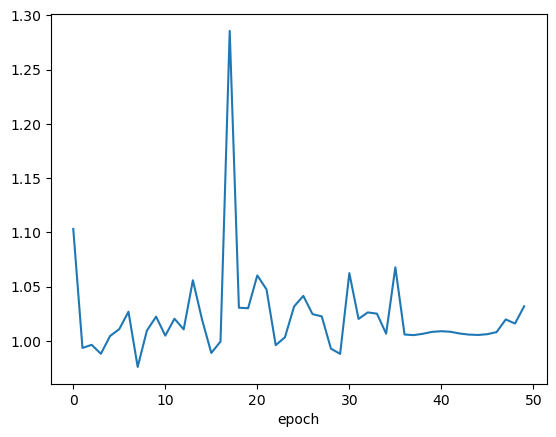

In [7]:
#model = model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.035)
loss_fn = F.mse_loss

start_time = time.perf_counter() # Start timer
num_epochs = 50
losses = []
outputs = []  #
targets = []  #
for epoch in range(num_epochs):
    loss = 0
    epoch_outputs = []  #
    epoch_targets = []  #
    H = torch.zeros(24,out_channels)
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time_step, snapshot in enumerate(train_dataset):
        #snapshot.to('cuda')
        output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale))  #
        epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale))   #

        # if torch.isnan(output).any():
        #     print(time_step)
    
    loss = loss/(time_step+1)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.cpu().detach().numpy())
    outputs.append(epoch_outputs)  #
    targets.append(epoch_targets)  #
    print('Training loss: ', losses[-1])

end_time = time.perf_counter() # End timer
print("Elapsed time: ", end_time - start_time) # Calculate elapsed time

plt.plot(losses)
plt.xlabel("epoch")

In [ ]:
# a=model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
# print(a)

In [ ]:
# print(epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)))
# print(epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)))

In [23]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[-1][i][j] for i in range(len(outputs[-1]))]
    tarhourlist = [targets[-1][i][j] for i in range(len(outputs[-1]))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [24]:
#Test set
test_outputs = []  #
test_targets = []  #
for time_step, snapshot in enumerate(test_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H)
    test_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #
#snapshot.x


In [25]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [26]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[1129.0027257959794,
 615.4622340383667,
 352.965076567639,
 559.7933041418128,
 688.3329810715614,
 1378.7034152669062,
 4489.819245942821,
 6651.68713615669,
 7789.391354270943,
 10134.528701930538,
 13554.29263623065,
 15175.083652954347,
 13419.600135171244,
 17132.833726135912,
 17662.422761465317,
 18971.078603924838,
 25342.936330859608,
 28740.18913524757,
 20107.35989572599,
 14337.42580382356,
 8743.403903330662,
 4506.887263426681,
 2224.569205439651,
 1878.9501263750017]

In [27]:
np.mean(mse_test)

9816.113306470594

In [28]:
mae_train = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mae_train.append(np.mean(absdiff))
mae_train

[16.14182557118995,
 15.655453422061337,
 13.745519273779482,
 13.003879706399475,
 13.244801136137209,
 14.752438242224436,
 27.450418446691188,
 30.87257920941836,
 36.77049952895837,
 40.947553548173666,
 52.922903650901354,
 63.17445245602663,
 61.25846986836218,
 65.77162710322395,
 68.08427881673849,
 68.70289561965602,
 81.82403059216797,
 96.1027328343959,
 65.43288911892051,
 55.95124046722663,
 47.40186794514573,
 43.90686466839401,
 22.650610573174355,
 23.697293702375234]

In [29]:
mse_train = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mse_train.append(np.mean(sqdiff))
mse_train

[987.4941121346928,
 823.0458022445754,
 513.3953843431826,
 422.3621653927895,
 497.37979647702906,
 666.0488446995571,
 3729.163177879139,
 4847.573453531344,
 6620.047558080551,
 8738.147703885918,
 12847.61131166339,
 17101.92435843798,
 17481.6222468022,
 19410.25306505528,
 20449.55422840534,
 20742.5835092246,
 23921.14061604026,
 30379.565615647505,
 18178.014409655854,
 13453.149136211856,
 10183.421243037392,
 8593.663511418383,
 2416.8032059573766,
 2118.8016313504913]

In [132]:
mae_test = []
for j in range(24):
    absdiff = [abs(a - b) for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mae_test.append(np.mean(absdiff))
mae_test

[8.571338173186087,
 7.4284146275119145,
 6.723312883919252,
 6.899924305983478,
 7.3371882961429264,
 9.261325055281086,
 20.003374382069584,
 25.350211970526832,
 28.282429686914163,
 35.34019667802603,
 46.4523176211669,
 51.656405244206965,
 48.120426467588956,
 54.96251416780379,
 53.04151781152348,
 55.73364002652367,
 70.1297460813341,
 79.08893909916335,
 56.38115977102551,
 46.16816225717808,
 35.60450945526961,
 25.06178849391564,
 13.801309216722146,
 13.39697024950497]

In [133]:
np.mean(mae_test)

33.53321341760369

In [134]:
mse_train_gconv = mse_train
mse_test_gconv = mse_test
mae_train_gconv = mae_train
mae_test_gconv = mae_test

In [46]:
mse_train_gconv = [round(v, 1) for v in mse_train_gconv]
mse_test_gconv = [round(v, 1) for v in mse_test_gconv]

In [25]:
mae_train_gconv = [round(v, 1) for v in mae_train_gconv]
mae_test_gconv = [round(v, 1) for v in mae_test_gconv]

In [26]:
import pandas as pd
df_mse = pd.DataFrame({'a': mse_train_gconv, 'b': mse_test_gconv, 'c': mae_train_gconv, 'd': mae_test_gconv})

# Esportare la tabella in formato LaTeX
latex_table = df_mse.to_latex(index=False)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
      a &       b &    c &    d \\
\midrule
  798.8 &   825.1 & 11.7 &  9.1 \\
  642.3 &   436.8 & 11.1 &  7.9 \\
  353.4 &   229.0 &  9.5 &  6.9 \\
  274.2 &   368.8 &  8.8 &  7.0 \\
  325.4 &   488.5 &  8.8 &  7.5 \\
  491.7 &  1157.5 & 10.4 &  9.5 \\
 3215.1 &  3669.5 & 22.6 & 19.9 \\
 3742.7 &  5318.3 & 25.3 & 24.5 \\
 5245.3 &  6224.9 & 30.9 & 27.2 \\
 7167.8 &  8446.9 & 35.3 & 34.0 \\
10166.5 & 11866.6 & 44.8 & 45.3 \\
13143.2 & 13076.9 & 52.4 & 50.4 \\
13367.6 & 11473.1 & 50.9 & 46.4 \\
14717.1 & 14885.0 & 54.2 & 53.3 \\
15182.5 & 14571.6 & 54.2 & 51.5 \\
15254.2 & 15721.8 & 54.9 & 55.1 \\
18438.6 & 21267.2 & 66.3 & 69.2 \\
22688.6 & 24400.5 & 75.2 & 77.6 \\
14220.4 & 16390.5 & 53.0 & 55.5 \\
10776.8 & 12377.8 & 45.4 & 46.0 \\
 8159.4 &  8058.3 & 39.1 & 35.7 \\
 6999.4 &  4244.2 & 37.0 & 25.0 \\
 1809.6 &  2117.0 & 17.9 & 14.4 \\
 1828.8 &  1634.4 & 19.4 & 13.5 \\
\bottomrule
\end{tabular}



In [27]:
df_mse.to_csv('../errors/errori_GConv.csv', index=False)

In [31]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [32]:
list_ids = loader._node_ids
dict = list_ids.item()
inverse_dict = {value: key for key, value in dict.items()}
inverse_dict.get(0)

'00:00'

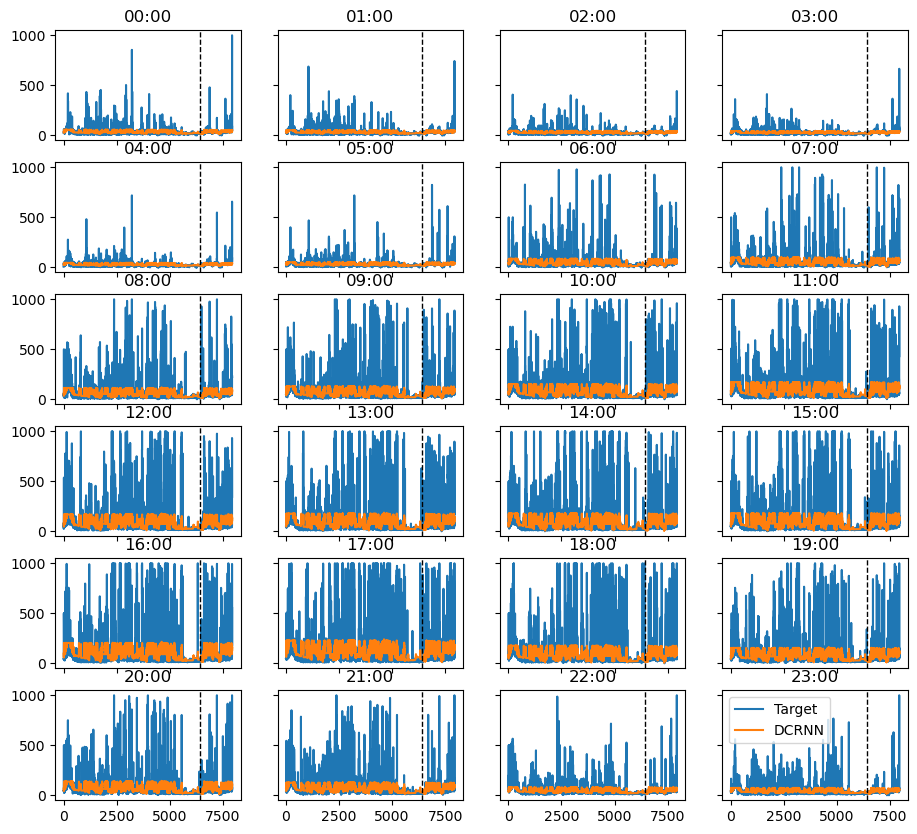

In [33]:
fig, axs = plt.subplots(6, 4, figsize=(11, 10), sharey=True, sharex=True)

# Iteriamo sulla lista delle matrici e le visualizziamo in subplots
for i in range(6):
    axs[i,0].plot(targets_merged[i*4], label="Target")
    axs[i,0].plot(outputs_merged[i*4], label=name_model)
    axs[i,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,1].plot(targets_merged[i*4+1], label="Target")
    axs[i,1].plot(outputs_merged[i*4+1], label=name_model)
    axs[i,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,2].plot(targets_merged[i*4+2], label="Target")
    axs[i,2].plot(outputs_merged[i*4+2], label=name_model)
    axs[i,2].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,3].plot(targets_merged[i*4+3], label="Target")
    axs[i,3].plot(outputs_merged[i*4+3], label=name_model)
    axs[i,3].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,0].set_title(inverse_dict[i*4])  # Titolo del subplot
    axs[i,1].set_title(inverse_dict[i*4+1])
    axs[i,2].set_title(inverse_dict[i*4+2])
    axs[i,3].set_title(inverse_dict[i*4+3])
    #axs[i].axis('off')  # Nasconde gli assi

plt.legend()
plt.savefig('../plot/dyn'+name_model.lower()+'.jpg', format='jpg')
# Mostriamo la figura con tutti i subplot
plt.show()

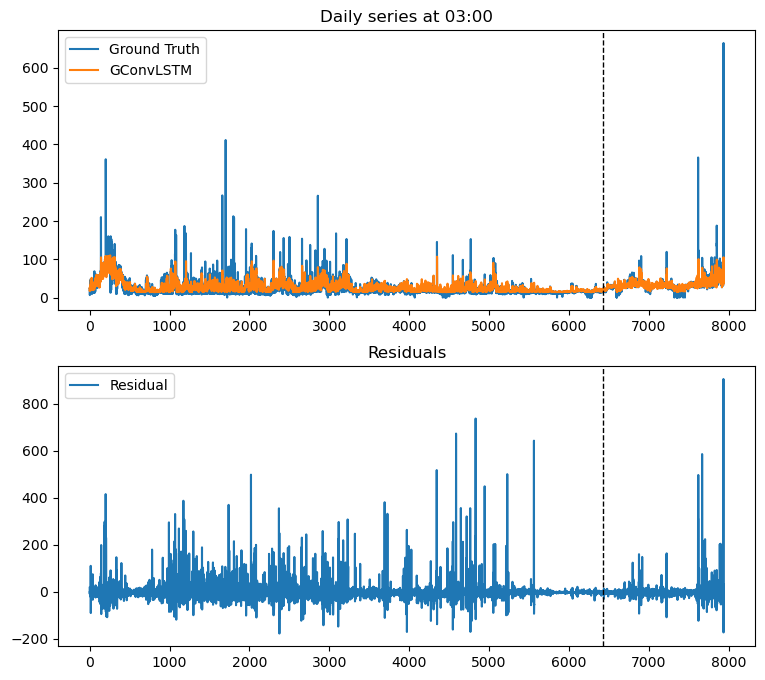

In [90]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label=name_model)
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

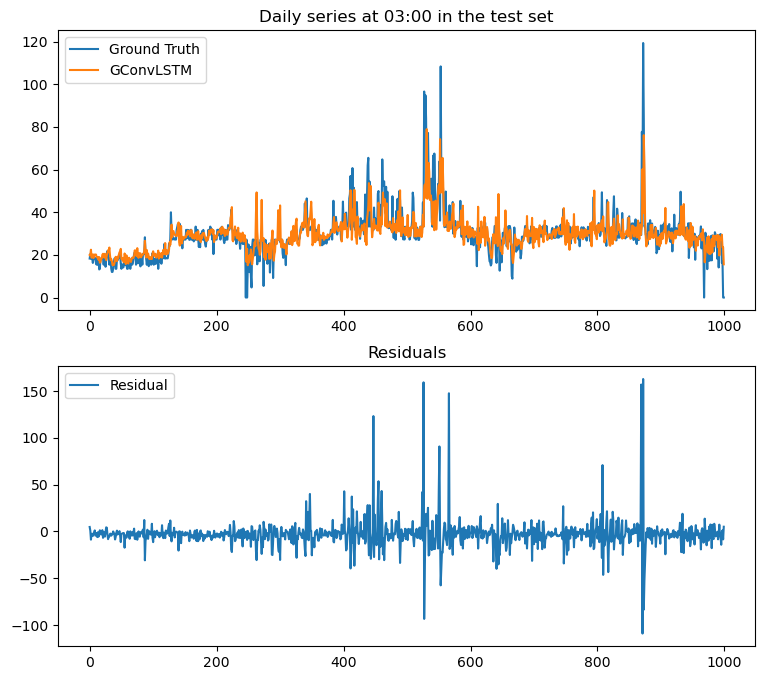

In [91]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label=name_model)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

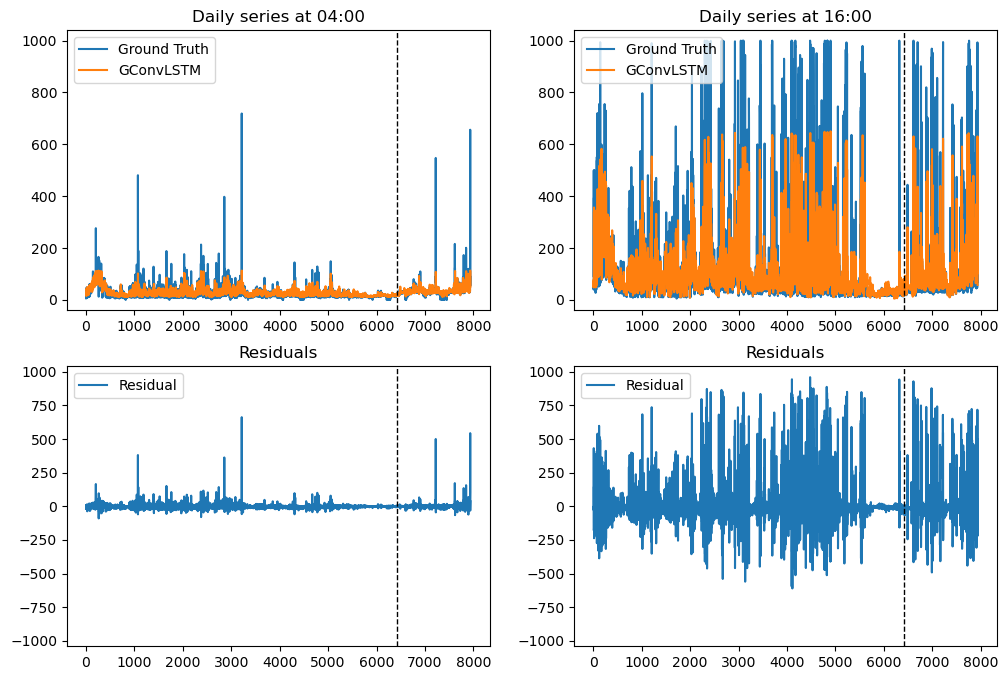

In [115]:
hour1 = 4
hour2 = 16

diff1 = [a - b for a, b in zip(targets_merged[hour1], outputs_merged[hour1])]
diff2 = [a - b for a, b in zip(targets_merged[hour2], outputs_merged[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_merged[hour1], label="Ground Truth")
axs[0,0].plot(outputs_merged[hour1], label=name_model)
axs[0,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,0].legend()
axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1])
axs[1,0].plot(diff1, label="Residual")
axs[1,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,0].legend()
axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_merged[hour2], label="Ground Truth")
axs[0,1].plot(outputs_merged[hour2], label=name_model)
axs[0,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,1].legend()
axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2])
axs[1,1].plot(diff2, label="Residual")
axs[1,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,1].legend()
axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focusdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

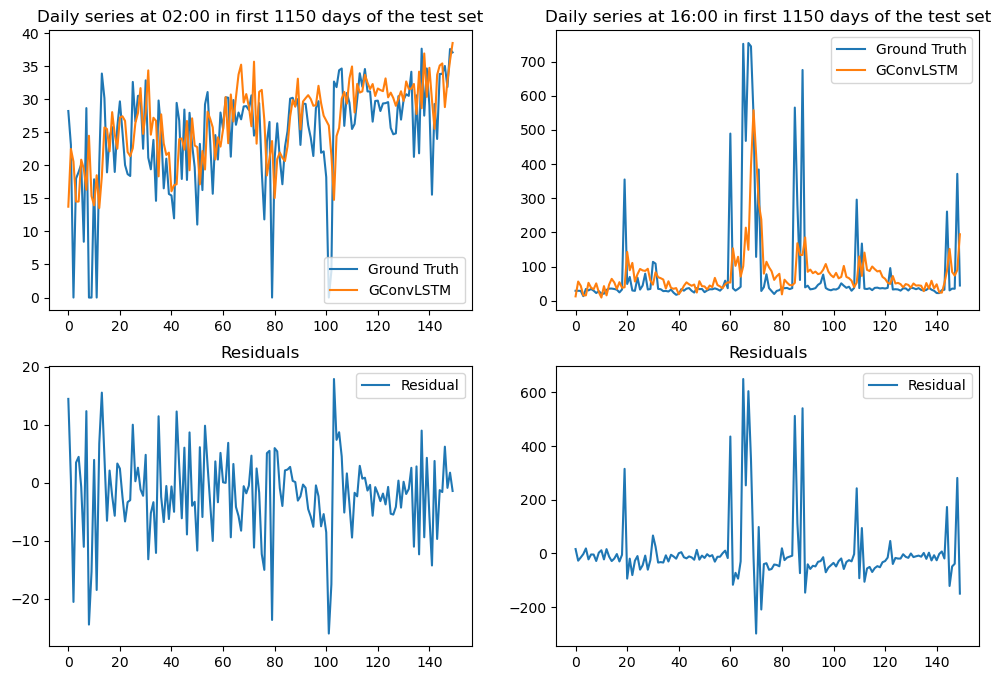

In [116]:
hour1 = 2
hour2 = 16
id=1000
fd=1150

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][id:fd], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][id:fd], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in first "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[id:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][id:fd], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][id:fd], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[id:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [35]:
##############

##############

##############
import pandas as pd
data_vec = pd.read_csv('../errors/vec.csv')
data_vec

x
0      55.475638
1      63.745574
2      52.759182
3      71.888373
4      80.559589
...          ...
7929  400.844548
7930  909.544470
7931  508.964608
7932  205.607561
7933  170.320681

[7934 rows x 1 columns]

In [38]:
hour1 = 2
hour2 = 16
id=140
#id=100
#id=1220
fd=id+150
train_size=6346
vec = data_vec.iloc[train_size+id:train_size+fd,0].to_list()
#vec

In [39]:
np.mean([(a - b)**2 for a, b in zip(targets_hourly_test[hour2][id:fd],vec)])

17503.044466971365

In [40]:
np.mean([(a - b)**2 for a, b in zip(targets_hourly_test[hour2][id:fd],outputs_hourly_test[hour2][id:fd])])

23244.392921525472

In [41]:
np.mean([abs(a - b) for a, b in zip(targets_hourly_test[hour2][id:fd],vec)])

49.460019682978746

In [42]:
np.mean([abs(a - b) for a, b in zip(targets_hourly_test[hour2][id:fd],outputs_hourly_test[hour2][id:fd])])

52.734332583079635

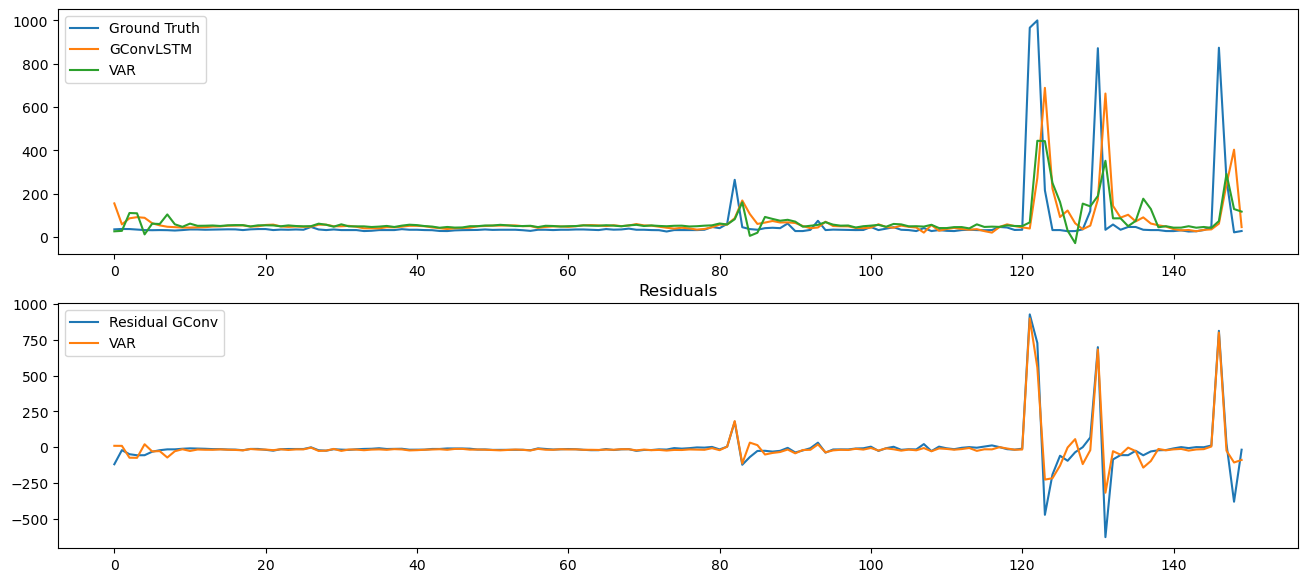

In [43]:
diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 1, figsize=(16, 7))
axs[0].plot(targets_hourly_test[hour2][id:fd], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour2][id:fd], label=name_model)
axs[0].plot(vec, label='VAR')
axs[0].legend()
#axs[0,1].set_ylim(-40,1040)
axs[1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1].plot(diff2[id:fd], label="Residual GConv")
axs[1].plot([a - b for a, b in zip(targets_hourly_test[hour2][id:fd],vec)], label='VAR')
axs[1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1].set_title("Residuals")
plt.show()

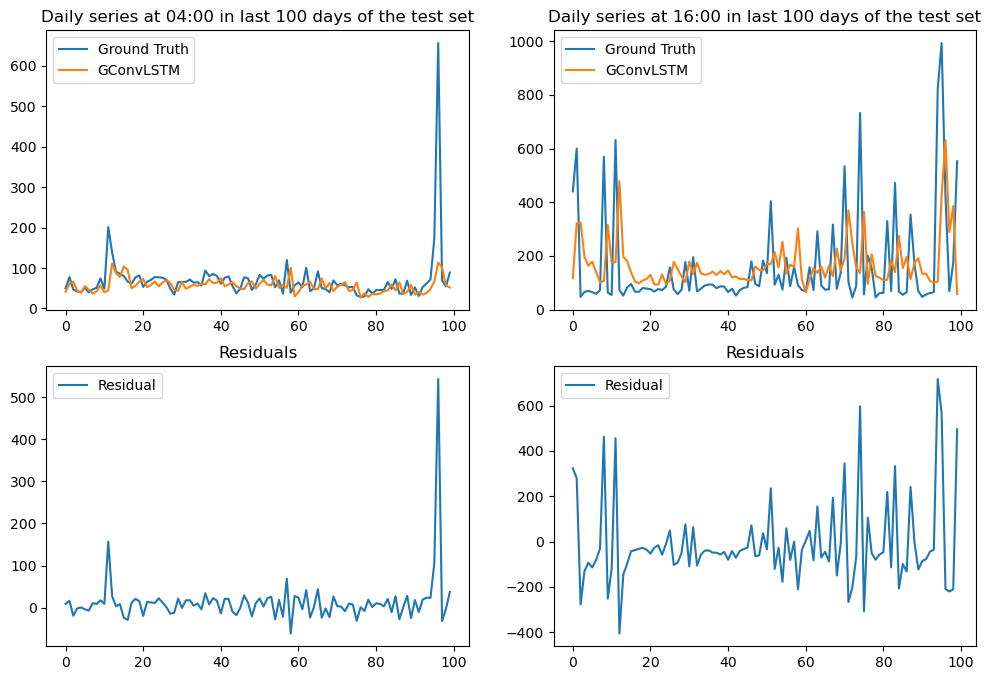

In [117]:
#o uno o l'altro
hour1 = 4
hour2 = 16
fd=100

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][-fd:], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][-fd:], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in last "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[-fd:], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][-fd:], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[-fd:], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [45]:
df_compare = pd.DataFrame({'a': outputs_hourly_test[hour1][-fd:], 'b': outputs_hourly_test[hour2][-fd:], 'c': diff1[-fd:], 'd': diff2[-fd:]})

In [58]:
# df_compare.to_csv('plot/compare/compare_gconv.csv', index=False)

In [46]:
evolve = pd.read_csv(r"../plot/compare/compare_evolve.csv")
tgcn = pd.read_csv(r"../plot/compare/compare_TGCN.csv")
gconv = pd.read_csv(r"../plot/compare/compare_gconv.csv")

In [47]:
name_model1 = 'EvolveGCNO'
name_model2 = 'TGCN'
name_model3 = 'GConvLSTM'

In [40]:
evolve.iloc[:,0]

0      38.344332
1      41.859223
2      52.664694
3      38.904612
4      39.747252
         ...    
95     44.277696
96    122.155089
97    229.241162
98     53.402143
99     64.822539
Name: a, Length: 100, dtype: float64

In [34]:
targets_hourly_test[hour1][-fd:][:50]

[49.919999828785606,
 77.64999878117446,
 46.899999629770605,
 41.55999956536897,
 39.909999848229155,
 50.76000052853523,
 39.500000059140824,
 47.19999998660818,
 50.78999996542783,
 74.07999992392776,
 48.749999335305816,
 201.01000359927997,
 137.92000220765084,
 90.40000197094813,
 85.97000129237885,
 79.82000295907596,
 66.34000149575921,
 61.40000140814837,
 76.75000070461752,
 81.44000249083425,
 53.109999830814466,
 65.7500005943816,
 70.61999900195393,
 77.68000121202283,
 76.72000126772491,
 75.72999889257862,
 71.1400012172488,
 48.53000047080429,
 34.27000017547889,
 64.8799989607615,
 65.39000136375883,
 65.61000022826036,
 71.10999878640042,
 63.63000146587931,
 65.02999913918028,
 56.849999988052915,
 93.75999878203507,
 79.73999847278415,
 85.26000264343084,
 79.79999734656934,
 61.110000863608334,
 75.68999964338849,
 79.34999980526877,
 55.57000006232235,
 37.11000001069356,
 48.3800002923855,
 76.679999024579,
 74.50000102229151,
 45.65000063791054,
 59.319998534880

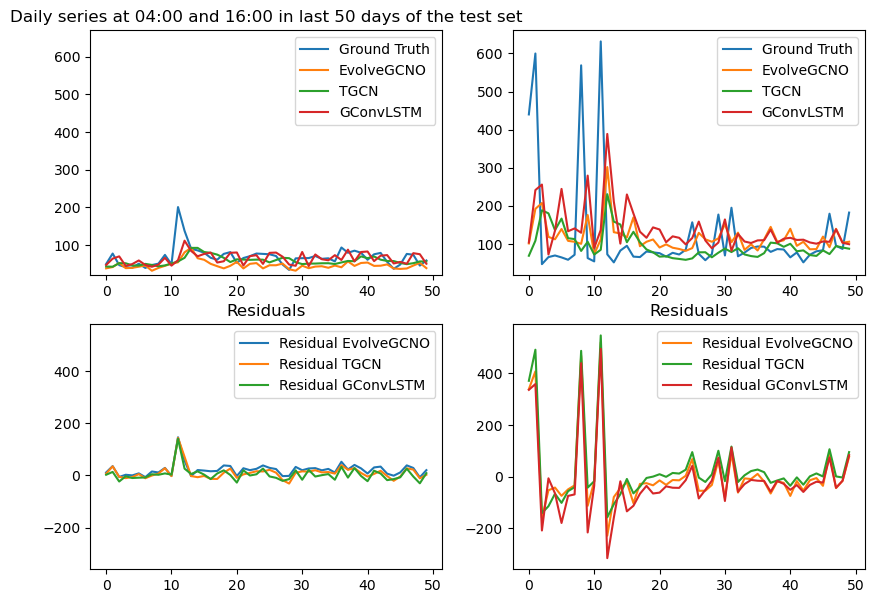

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs[0,0].plot(targets_hourly_test[hour1][-fd:][:50], label="Ground Truth")
axs[0,0].plot(evolve.iloc[:50,0], label=name_model1)
axs[0,0].plot(tgcn.iloc[:50,0], label=name_model2)
axs[0,0].plot(gconv.iloc[:50,0], label=name_model3)
axs[0,0].set_ylim([20,670])
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" and "+inverse_dict[hour2]+" in last 50 days of the test set")
axs[1,0].plot(evolve.iloc[:50,2], label="Residual "+name_model1)
axs[1,0].plot(tgcn.iloc[:50,2], label="Residual "+name_model2)
axs[1,0].plot(gconv.iloc[:50,2], label="Residual "+name_model3)
axs[1,0].set_ylim([-360,580])
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:][:50], label="Ground Truth")
axs[0,1].plot(evolve.iloc[:50,1], label=name_model1, color=plt.get_cmap("tab10")(1))
axs[0,1].plot(tgcn.iloc[:50,1], label=name_model2, color=plt.get_cmap("tab10")(2))
axs[0,1].plot(gconv.iloc[:50,1], label=name_model3, color=plt.get_cmap("tab10")(3))
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
#axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last "+str(fd)+" days of the test set")
axs[1,1].plot(evolve.iloc[:50,3], label="Residual "+name_model1, color=plt.get_cmap("tab10")(1))
axs[1,1].plot(tgcn.iloc[:50,3], label="Residual "+name_model2, color=plt.get_cmap("tab10")(2))
axs[1,1].plot(gconv.iloc[:50,3], label="Residual "+name_model3, color=plt.get_cmap("tab10")(3))
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('../plot/compare.jpg', format='jpg')
plt.show()

In [48]:
output_list = [outputs_hourly_test[i] for i in range(24)]
target_list = [targets_hourly_test[i] for i in range(24)]

In [68]:
dit_o_test = {}
dit_t_test = {}
for i, lista in enumerate(output_list, start=1):
    nome_colonna = f'Hour {i}'
    dit_o_test[nome_colonna] = lista
    
for i, lista in enumerate(target_list, start=1):
    nome_colonna = f'Hour {i}'
    dit_t_test[nome_colonna] = lista
    
df_t_test = pd.DataFrame(dit_t_test)
df_o_test = pd.DataFrame(dit_o_test)
#df_t_test

In [69]:
df_var = pd.read_csv('../errors/var_test.csv')
df_var = df_var.iloc[train_size:,:]
#df_var

In [64]:
# target_ = df_t_test#df_o_test
# output_var = df_var#df_o_test
# output_model = df_o_test

In [75]:
j = 0
target_ = df_t_test.iloc[30+j*365:j*365+120,:]
output_model = df_o_test.iloc[30+j*365:j*365+120,:]
output_var = df_var.iloc[30+j*365:j*365+120,:]
#df_o_test

In [104]:
j = 3
target_2 = df_t_test.iloc[260+j*365:j*365+350,:]
output_model2 = df_o_test.iloc[260+j*365:j*365+350,:]
output_var2 = df_var.iloc[260+j*365:j*365+350,:]
#df_o_test

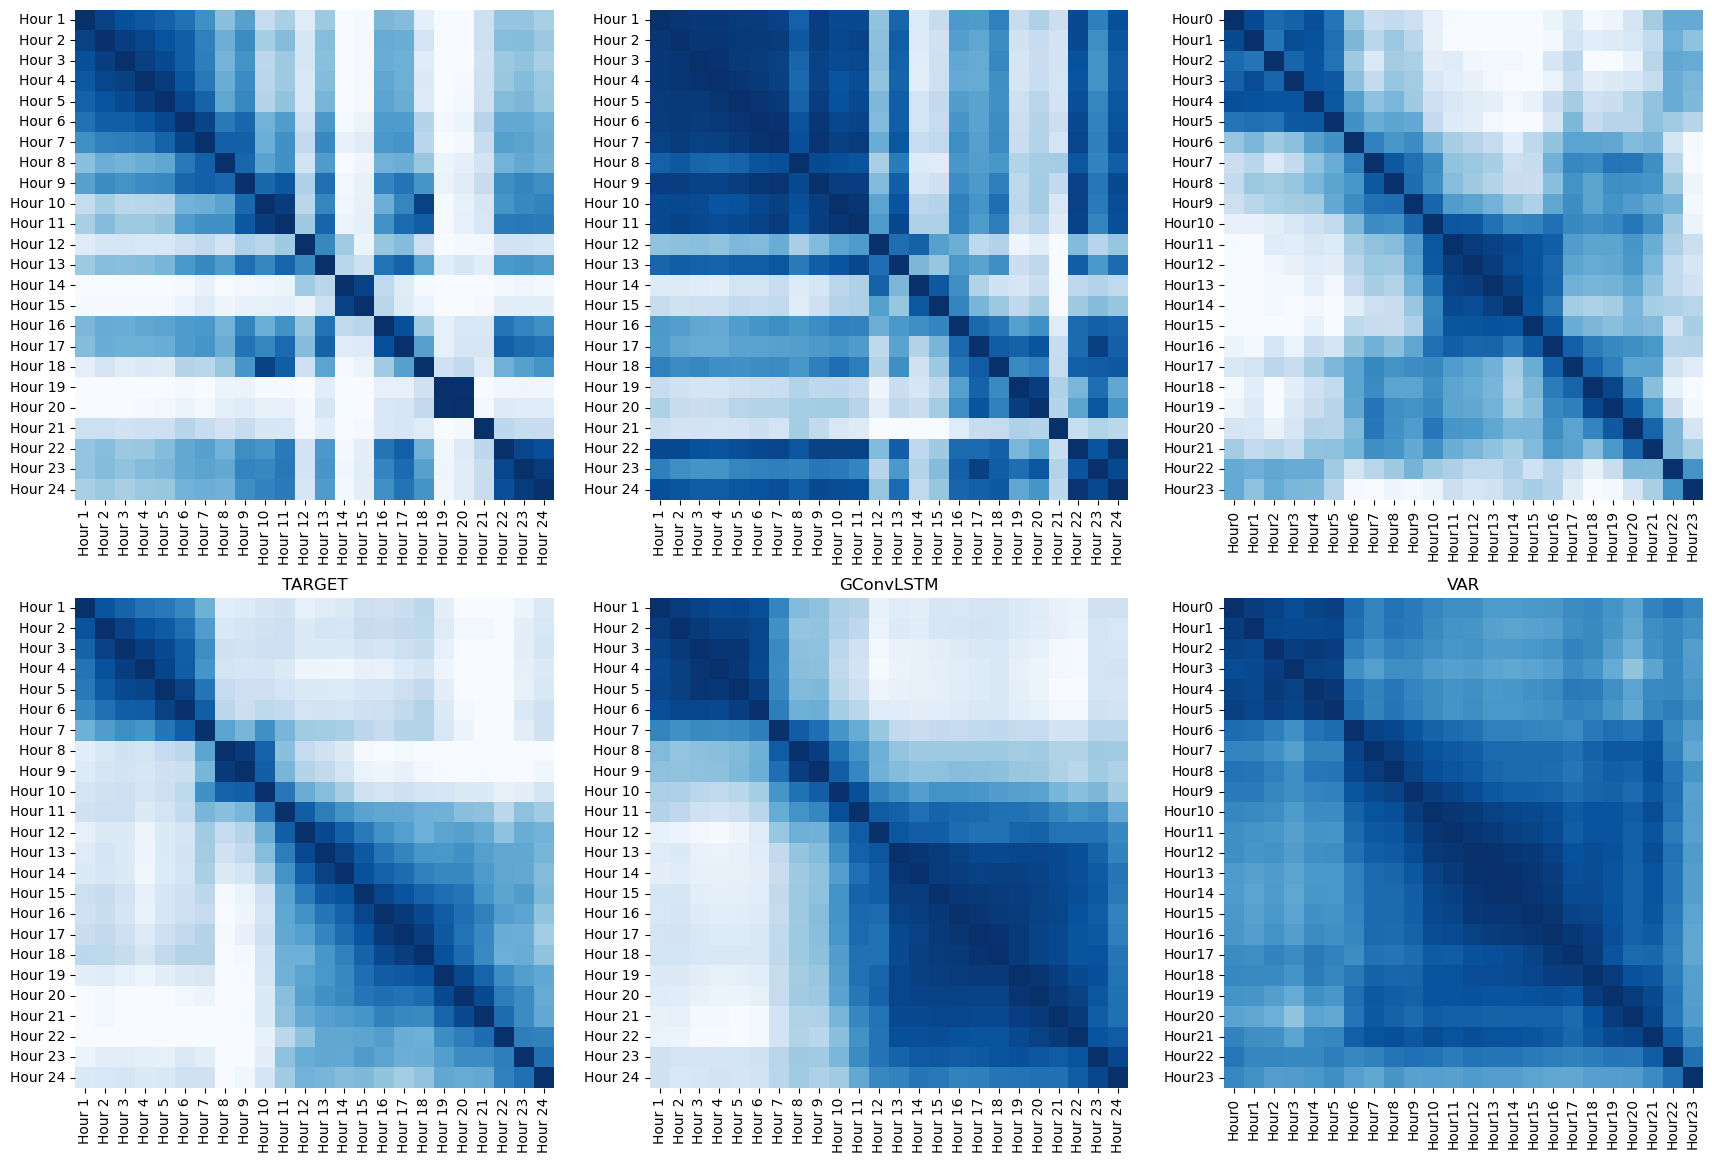

In [106]:
import seaborn as sb
fig, ax = plt.subplots(2,3, figsize=(21,14))
ax[1,0].set_title('TARGET')
ax[1,1].set_title('GConvLSTM')
ax[1,2].set_title('VAR')
sb.heatmap(target_.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[0,0])
sb.heatmap(output_model.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[0,1])
sb.heatmap(output_var.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[0,2])
sb.heatmap(target_2.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[1,0])
sb.heatmap(output_model2.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[1,1])
sb.heatmap(output_var2.corr(), cmap="Blues", vmin=0, vmax=1, annot=False, cbar=False, ax=ax[1,2])
#plt.savefig('plot/comparecorr.jpg', format='jpg')
plt.show()

In [35]:

# Per salvare modello
#model = model.to('cpu')
#torch.save(model.state_dict(), '../models/gnn_dyn'+name_model+'_3_10_5_0.075.pth')


In [11]:
# Per caricare modello
model = RecurrentGCN(node_features = lags)
model.load_state_dict(torch.load('../models/gnn_dyn'+name_model+'_3_10_5_0.075.pth'))
#model = model.to('cuda')
print(model)

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_i): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_f): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_f): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_c): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_c): ChebConv(10, 10, K=5, normalization=sym)
    (conv_x_o): ChebConv(3, 10, K=5, normalization=sym)
    (conv_h_o): ChebConv(10, 10, K=5, normalization=sym)
  )
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [13]:
#Training set
H = torch.zeros(24,out_channels)
outputs = []  #
targets = []  #
for time_step, snapshot in enumerate(train_dataset):
    #snapshot.to('cuda')
    output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
    train_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    train_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    outputs.append(train_output)  #
    targets.append(train_snapshot)   #

In [14]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[i][j] for i in range(len(outputs))]
    tarhourlist = [targets[i][j] for i in range(len(outputs))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)